<a href="https://colab.research.google.com/github/Bruce-0113/Image_classification/blob/main/Fruits_360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset

* [How to download the data from kaggle](https://nancysw.medium.com/%E5%85%A9%E7%A8%AE%E5%8F%96%E7%94%A8-kaggle-%E8%B3%87%E6%96%99%E9%9B%86%E7%9A%84%E6%96%B9%E6%B3%95-5944a1bcebf3)
* [Dataset](https://www.kaggle.com/datasets/moltean/fruits/data)



In [ ]:
# Download kaggle data in Google Colab
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"s24578111","key":"3945fb43a5d4b3c5f187a6863401c94a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 1.28G/1.28G [00:07<00:00, 121MB/s]
100% 1.28G/1.28G [00:08<00:00, 172MB/s]


In [ ]:
!ls -l

total 1347356
-rw-r--r-- 1 root root 1379678841 Sep 12  2021 fruits.zip
-rw-r--r-- 1 root root         65 Mar  6 10:57 kaggle.json
drwxr-xr-x 1 root root       4096 Mar  4 14:28 sample_data


In [ ]:
! mkdir fruits-360_data

In [ ]:
! unzip fruits.zip -d fruits-360_data

In [ ]:
!ls fruits-360_data

fruits-360_dataset  fruits-360-original-size


# Import Packages

In [ ]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

## Parameters setting

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100]

# training config:
epochs = 10
batch_size = 32

# train_path = 'fruits-360_data/fruits-360-original-size/fruits-360-original-size/Training'
# valid_path = 'fruits-360_data/fruits-360-original-size/fruits-360-original-size/Validation'
train_path = 'fruits-360_data/fruits-360_dataset/fruits-360/Training'
test_path = 'fruits-360_data/fruits-360_dataset/fruits-360/Test'

Number of training data :  67692
Number of validation data :  22688
Number of classes :  131


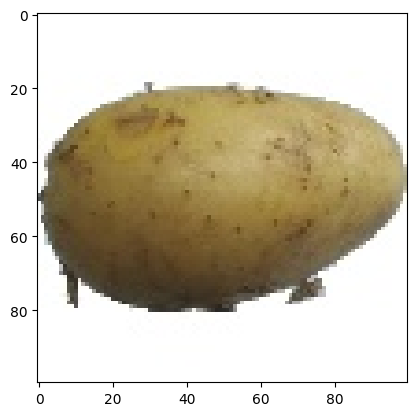

In [ ]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(test_path + '/*/*.jp*g')
print('Number of training data : ', len(image_files))
print('Number of validation data : ', len(valid_image_files))

# useful for getting number of classes
folders = glob(train_path + '/*')
print('Number of classes : ', len(folders))


# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# froze the original weights of VGG
for layer in vgg.layers:
    layer.trainable = False

# output layers
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

In [ ]:
# Compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

### Data Generator

In [ ]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

labels = [None] * len(train_generator.class_indices)
for k, v in train_generator.class_indices.items():
  labels[v] = k


Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Model Training and Evaluation

### Fit the model

In [ ]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


Epoch 1/10
2115/2115 [==============================] - 310s 144ms/step - loss: 1.7017 - accuracy: 0.8797 - val_loss: 1.9700 - val_accuracy: 0.8942
Epoch 2/10
2115/2115 [==============================] - 304s 144ms/step - loss: 0.3545 - accuracy: 0.9686 - val_loss: 1.6150 - val_accuracy: 0.9197
Epoch 3/10
2115/2115 [==============================] - 304s 144ms/step - loss: 0.2474 - accuracy: 0.9788 - val_loss: 1.2703 - val_accuracy: 0.9388
Epoch 4/10
2115/2115 [==============================] - 299s 141ms/step - loss: 0.1820 - accuracy: 0.9844 - val_loss: 1.2432 - val_accuracy: 0.9414
Epoch 5/10
2115/2115 [==============================] - 305s 144ms/step - loss: 0.1378 - accuracy: 0.9872 - val_loss: 1.2558 - val_accuracy: 0.9432
Epoch 6/10
2115/2115 [==============================] - 304s 144ms/step - loss: 0.1334 - accuracy: 0.9885 - val_loss: 1.2550 - val_accuracy: 0.9437
Epoch 7/10
2115/2115 [==============================] - 308s 145ms/step - loss: 0.1142 - accuracy: 0.9901 - val_

### Evaluate the model

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  import itertools
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


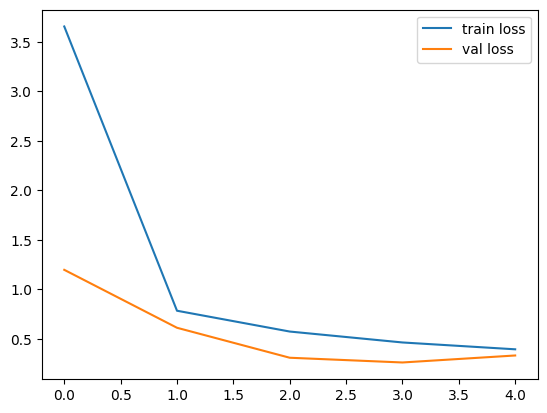

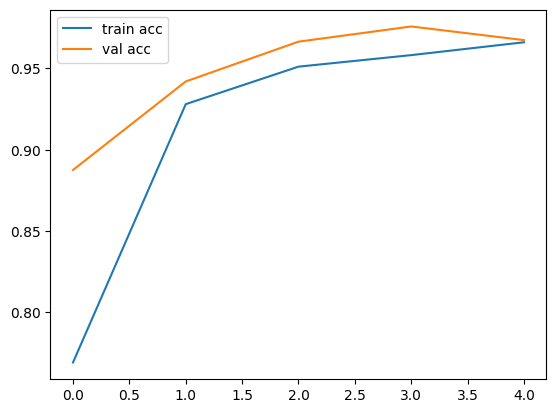

In [ ]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Plot confusion matrix
# plot_confusion_matrix(cm, labels, title='Train confusion matrix')
# plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')